In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression


def load_raw(path, h, w):
    data = np.fromfile(path, dtype=np.uint16)
    return data.reshape((h, w))


def normalize(x: pd.DataFrame):
    scaler = MinMaxScaler()
    return scaler.fit_transform(x.values.reshape(-1, 1)).flatten()


def fit_linear_model(x, y):
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)
    return model


def model_kb(x, x_hat):

    def mfunc(params, x_hat):
        k, b = params
        y_hat = k * x_hat + b
        return y_hat

    def cost_func(params, x_hat, x):
        pred = mfunc(params, x_hat)
        return np.mean((x - pred) ** 2)

    initial_params = [1.0, 0]  # Starting values for k, b

    result = minimize(cost_func, initial_params, args=(x_hat, x), method="Nelder-Mead")

    print("Optimization Results:")
    print("Parameters (k, b):", result.x)
    print("Minimum MSE:", result.fun)
    if result.success:
        print("The optimization converged successfully.")
    else:
        print("The optimization did not converge:", result.message)

    return result


def model_kbd(actual_depth: pd.DataFrame, disp: pd.DataFrame, focal, baseline):
    # disp_norm = normalize(disp)
    disp_norm = disp

    def mfunc(params, disp_norm, baseline, focal):
        k, delta, b = params
        y_hat = k * focal * baseline / (disp_norm + delta) + b
        return y_hat

    # Define the cost function (MSE)
    def cost_func(params, disp_norm, baseline, focal, actual_depth):
        predictions = mfunc(params, disp_norm, baseline, focal)
        # return np.mean((actual_depth - predictions) ** 2)
        return np.mean((actual_depth - predictions) ** 2)

    # Initial guess for the parameters and bounds
    initial_params = [1.0, 0.01, 10]  # Starting values for k, delta, b
    # bounds = [(0.1, 100), (0, 1), (-50, 50)]  # Expanded bounds for parameters

    result = minimize(
        cost_func,
        initial_params,
        args=(disp_norm, baseline, focal, actual_depth),
        method="Nelder-Mead",
    )

    print("Optimization Results:")
    print("Parameters (k, delta, b):", result.x)
    print("Minimum MSE:", result.fun)
    if result.success:
        print("The optimization converged successfully.")
    else:
        print("The optimization did not converge:", result.message)

    return result


def model_kbd_further_optimized(actual_depth, disp, focal, baseline, reg_lambda=0.001):
    # disp_norm = normalize(disp)
    disp_norm = disp

    def mfunc(params, disp_norm, baseline, focal):
        k, delta, b = params
        y_hat = k * focal * baseline / (disp_norm + delta) + b
        return y_hat

    def cost_func(params, disp_norm, baseline, focal, actual_depth):
        predictions = mfunc(params, disp_norm, baseline, focal)
        mse = np.mean((predictions - actual_depth) ** 2)
        # Adding L2 regularization
        regularization = reg_lambda * np.sum(np.square(params))
        return mse + regularization

    # Adjusting initial parameters and bounds based on previous results
    initial_params = [1.0, 0.01, 0]  # Modified initial values for k, delta, b
    # bounds = [(None, None), (0, 1), (None, None)]  # Expanded bounds for parameters

    # Using a different optimization method: 'TNC'
    result = minimize(
        cost_func,
        initial_params,
        args=(disp_norm, baseline, focal, actual_depth),
        method="Nelder-Mead",
    )

    print("Optimization Results:")
    print("Parameters (k, delta, b):", result.x)
    print("Minimum MSE:", result.fun)
    if result.success:
        print("The optimization converged successfully.")
    else:
        print("The optimization did not converge:", result.message)

    return result


def model_kbd_joint_linear(
    actual_depth, disp, focal, baseline, disjoint_depth_range=(400, 600, 2700, 2900)
):
    """
    Fit the KBD model to the data where actual_depth >= 500.

    Parameters:
    actual_depth (np.ndarray): The actual depth measurements.
    disp (np.ndarray): The disparity measurements corresponding to the actual depths.
    focal (float): Focal length of the camera.
    baseline (float): Baseline distance between cameras.

    Returns:
    tuple: A tuple containing the linear model for the joint point and the optimization result.
    """

    def mfunc(params, disp, baseline, focal):
        k, delta, b = params
        return k * focal * baseline / (disp + delta) + b

    def cost_func(params, disp, baseline, focal, actual_depth):
        predictions = mfunc(params, disp, baseline, focal)
        return np.mean((actual_depth - predictions) ** 2)

    # Filter data where actual_depth >= 500
    mask = np.where(actual_depth >= disjoint_depth_range[0])
    filtered_disp = disp[mask]
    filtered_depth = actual_depth[mask]

    # Fit the model on the filtered data
    initial_params = [1.0, 0.01, 10]  # Reasonable starting values
    result = minimize(
        cost_func,
        initial_params,
        args=(filtered_disp, baseline, focal, filtered_depth),
        method="Nelder-Mead",
    )

    # find the estimiated disparity to depth range within [500, 600]
    fb = focal * baseline
    k_, delta_, b_ = result.x
    d_sup = fb / disjoint_depth_range[0]
    d_inf = fb / disjoint_depth_range[1]

    d_sup_2 = fb / disjoint_depth_range[2]
    d_inf_2 = fb / disjoint_depth_range[3]

    depth_estimated_d_sup = k_ * fb / (d_inf + delta_) + b_
    depth_estimated_d_sup_2 = k_ * fb / (d_sup_2 + delta_) + b_

    actual_disp = fb / actual_depth

    # Fit linear model for the range [400, 600] to ensure continuity
    mask_linear = np.where(
        (actual_depth >= disjoint_depth_range[0]) & (actual_depth <= depth_estimated_d_sup)
    )
    x_linear = disp[mask_linear]
    y_linear = actual_disp[mask_linear]
    linear_model = fit_linear_model(x_linear, y_linear)

    # Fit linear model for the range [2900, 3100] to ensure continuity
    mask_linear2 = np.where(
        (actual_depth >= depth_estimated_d_sup_2) & (actual_depth <= disjoint_depth_range[3])
    )
    x_linear2 = disp[mask_linear2]
    y_linear2 = actual_disp[mask_linear2]
    linear_model2 = fit_linear_model(x_linear2, y_linear2)

    return linear_model, result, linear_model2


def model_kbd_segmented(actual_depth, disp, focal, baseline, depth_ranges):
    """
    Perform piecewise optimization on depth data using given segments, ensuring continuity at joint points.

    Parameters:
    actual_depth (np.ndarray): The actual depth measurements.
    disp (np.ndarray): The disparity measurements corresponding to the actual depths.
    focal (float): Focal length of the camera.
    baseline (float): Baseline distance between cameras.
    depth_ranges (list of tuples): List of tuples specifying the depth ranges for each segment.

    Returns:
    dict: A dictionary containing optimization results for each segment.
    """

    def mfunc(params, disp, baseline, focal):
        k, delta, b = params
        return k * focal * baseline / (disp + delta) + b

    def cost_func(params, disp, baseline, focal, actual_depth):
        predictions = mfunc(params, disp, baseline, focal)
        return np.mean((actual_depth - predictions) ** 2)

    results = {}
    initial_params = [1.0, 0.01, 10]  # Reasonable starting values

    for idx, (start, end) in enumerate(depth_ranges):
        # Find indices within the specified depth range
        indices = np.where((actual_depth >= start) & (actual_depth <= end))[0]
        segment_disp = disp[indices]
        segment_depth = actual_depth[indices]

        result = minimize(
            cost_func,
            initial_params,
            args=(segment_disp, baseline, focal, segment_depth),
            method="Nelder-Mead",
        )

        results[(start, end)] = result
        initial_params = (
            result.x
        )  # Use optimized parameters as initial for next segment

    return results


def model_poly_n2(actual_depth, disp, focal, baseline, reg_lambda=0.001):
    def mfunc(params, disp, baseline, focal):
        a, b, c, d = params
        y_hat = focal * baseline / (a * disp**2 + b * disp + c) + d
        return y_hat

    def cost_func(params, disp, baseline, focal, actual_depth):
        predictions = mfunc(params, disp, baseline, focal)
        mse = np.mean((predictions - actual_depth) ** 2)
        regularization = reg_lambda * np.sum(np.square(params))
        return mse + regularization

    initial_params = [0, 1.0, 0, 0]
    result = minimize(
        cost_func,
        initial_params,
        args=(disp, baseline, focal, actual_depth),
        method="Nelder-Mead",
    )

    print("Optimization Results:")
    print("Parameters (k, delta, b):", result.x)
    print("Minimum MSE:", result.fun)
    if result.success:
        print("The optimization converged successfully.")
    else:
        print("The optimization did not converge:", result.message)

    return result


def plot_residuals(residuals, error, gt):
    plt.figure(figsize=(10, 6))
    plt.scatter(gt, residuals, alpha=0.5, color="blue", label="fitted residuals")
    plt.scatter(gt, error, alpha=0.5, color="green", label="actual residuals")
    plt.hlines(
        0,
        xmin=0,
        xmax=np.max(gt),
        colors="red",
        linestyles="dashed",
        label="Zero Error Line",
    )
    plt.xlabel("Ground truth distance (mm)")
    plt.ylabel("Residuals (Error) vs original error")
    plt.title("Residuals Plot")
    plt.legend()
    plt.show()

    # Print the mean of the residuals
    mean_residuals = np.mean(residuals)
    print("Mean of residuals:", mean_residuals)


def plot_error_rate(
    residuals: np.ndarray,
    error: np.ndarray,
    nominator: np.ndarray,
    save_path: str = None,
):
    plt.figure(figsize=(10, 6))
    plt.scatter(
        nominator,
        residuals / nominator * 100,
        alpha=0.5,
        color="blue",
        label="fitted residuals",
    )
    plt.scatter(
        nominator,
        error / nominator * 100,
        alpha=0.5,
        color="green",
        label="actual residuals",
    )
    plt.hlines(
        0,
        xmin=0,
        xmax=np.max(nominator),
        colors="red",
        linestyles="dashed",
        label="Zero Error Line",
    )
    plt.hlines(
        2,
        xmin=0,
        xmax=np.max(nominator),
        colors="green",
        linestyles="dashed",
        label="2(%) error Line",
    )
    plt.hlines(
        -2,
        xmin=0,
        xmax=np.max(nominator),
        colors="green",
        linestyles="dashed",
        label="2(%) error Line",
    )
    plt.hlines(
        4,
        xmin=0,
        xmax=np.max(nominator),
        colors="blue",
        linestyles="dashed",
        label="4(%) error Line",
    )
    plt.hlines(
        -4,
        xmin=0,
        xmax=np.max(nominator),
        colors="blue",
        linestyles="dashed",
        label="4(%) error Line",
    )
    plt.xlabel("Ground truth distance (mm)")
    plt.ylabel("Residuals (Error) rate vs original error rate (%)")
    plt.title("Error rate Plot (%)")
    plt.legend()
    if save_path:
        plt.savefig(save_path)
    plt.show()


def plot_comparison(x, y1, y2):
    fig, ax = plt.subplots()
    ax.plot(x, y1, label="measured data", marker="o")
    ax.plot(x, y2, label="fitted data", marker="x")

    ax.legend()
    plt.show()


def plot_illustration_fig(lraw_path, depth_path):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    lraw = mpimg.imread(lraw_path)
    h, w = lraw.shape[0], lraw.shape[1]
    depth = load_raw(depth_path, h, w)

    axs[0].imshow(lraw)
    axs[0].axis("off")
    axs[0].set_title("left raw image")

    # Show second image
    axs[1].imshow(depth)
    axs[1].axis("off")
    axs[1].set_title("depth image")

    # Adjust layout
    plt.tight_layout()
    plt.show()


def plot_comparison4(x, y1, y2, y3, y4):
    fig, ax = plt.subplots()
    ax.plot(x, y1, label="fitted data", marker="o")
    ax.plot(x, y2, label="center half size crop", marker="x")
    ax.plot(x, y3, label="center 50x50 crop", marker="x")
    ax.plot(x, y4, label="center 50x50 crop with anchor", marker="x")

    ax.legend()
    plt.show()


def linear_fitting(X, y):
    model = LinearRegression()
    model.fit(X, y)
    k = model.coef_
    b = model.intercept_

    print("Slope (k):", k)
    print("Intercept (b):", b)
    return model


def pipeline(
    gt,
    est,
    error,
    focal=None,
    baseline=None,
    method="KB",
    desc="",
    reg_lambda=None,
    depth_ranges=None,
    disjoint_depth_ranges=None,
):
    assert method in ("KB", "KBD", "KBD_reg", "poly_n2", "KBD_seg", "KBD_linear")
    if method == "KB":
        print(f"Starting optimization for KB model with {desc} ...")
        res = model_kb(gt, est)
        params = res.x
        pred = params[0] * est + params[1]
        residual = pred - gt
        plot_residuals(residual, error, gt)
        plot_error_rate(residual, error, gt)
        plot_comparison(gt, est, pred)

    elif method == "KBD" and focal is not None and baseline is not None:
        print(f"Starting optimization for KBD model with {desc} ...")
        res = model_kbd(gt, est, focal, baseline)
        params = res.x
        pred = params[0] * focal * baseline / (est + params[1]) + params[2]
        residual = pred - gt
        plot_residuals(residual, error, gt)
        plot_error_rate(residual, error, gt)
        plot_comparison(gt, focal * baseline / est, pred)

    elif (
        method == "KBD_reg"
        and focal is not None
        and baseline is not None
        and reg_lambda is not None
    ):
        print(f"Starting optimization for KBD L2 regularization model with {desc} ...")
        res = model_kbd_further_optimized(
            gt, est, focal, baseline, reg_lambda=reg_lambda
        )
        params = res.x
        pred = params[0] * focal * baseline / (est + params[1]) + params[2]
        residual = pred - gt
        plot_residuals(residual, error, gt)
        plot_error_rate(residual, error, gt)
        plot_comparison(gt, focal * baseline / est, pred)

    elif (
        method == "poly_n2"
        and focal is not None
        and baseline is not None
        and reg_lambda is not None
    ):
        print(
            f"Starting optimization for 2 degrees polynomial L2 regularization model with {desc} ..."
        )
        res = model_poly_n2(gt, est, focal, baseline, reg_lambda=reg_lambda)
        params = res.x
        pred = (
            focal * baseline / (params[0] * est**2 + params[1] * est + params[2])
            + params[3]
        )
        residual = pred - gt
        plot_residuals(residual, error, gt)
        plot_error_rate(residual, error, gt)
        plot_comparison(gt, focal * baseline / est, pred)

    elif (
        method == "KBD_seg"
        and focal is not None
        and baseline is not None
        and depth_ranges is not None
    ):
        print(
            f"Starting optimization for piecewise KBD model optimization with {desc} ..."
        )
        res = model_kbd_segmented(gt, est, focal, baseline, depth_ranges=depth_ranges)
        plot_unified_results1(gt, est, error, focal, baseline, depth_ranges, res)
    
    elif (
        method == "KBD_linear"
        and focal is not None
        and baseline is not None
        and disjoint_depth_ranges is not None
    ):
        print(
            f"Starting optimization for piecewise KBD model optimization with {desc} ..."
        )
        res = model_kbd_joint_linear(gt, est, focal, baseline, disjoint_depth_ranges)
        plot_linear(gt, est, error, focal, baseline, res, disjoint_depth_ranges)


def plot_linear(gt, est, error, focal, baseline, res, disjoint_depth_range):
    linear_model, optimization_result, linear_model2 = res

    # Filter data where actual_depth >= 600
    mask0 = np.where(gt < disjoint_depth_range[0])
    mask1 = np.where((gt >= disjoint_depth_range[0]) & (gt <= disjoint_depth_range[1]))
    mask2 = (gt > disjoint_depth_range[1]) & (gt <= disjoint_depth_range[2])
    mask3 = (gt > disjoint_depth_range[2]) & (gt <= disjoint_depth_range[3])
    mask4 = gt > disjoint_depth_range[3]


    filtered_disp0 = est[mask0]
    filtered_depth0 = gt[mask0]
    error0 = error[mask0]
    pred0 = gt[mask0]
    residual0 = pred0 - filtered_depth0


    filtered_disp1 = est[mask1]
    filtered_depth1 = gt[mask1]
    error1 = error[mask1]
    pred_1_disp = linear_model.predict(filtered_disp1.reshape(-1, 1))
    pred1 = focal * baseline / pred_1_disp
    residual1 = pred1 - filtered_depth1


    filtered_disp2 = est[mask2]
    filtered_depth2 = gt[mask2]
    error2 = error[mask2]

    # Get optimized parameters
    optimized_params = optimization_result.x
    pred2 = optimized_params[0] * focal * baseline / (filtered_disp2 + optimized_params[1]) + optimized_params[2]
    residual2 = pred2 - filtered_depth2

    filtered_disp3 = est[mask3]
    filtered_depth3 = gt[mask3]
    error3 = error[mask3]
    pred_3_disp = linear_model2.predict(filtered_disp3.reshape(-1, 1))
    pred3 = focal * baseline / pred_3_disp
    residual3 = pred3 - filtered_depth3

    filtered_disp4 = est[mask4]
    filtered_depth4 = gt[mask4]
    error4 = error[mask4]
    pred4 = gt[mask4]
    residual4 = pred4 - filtered_depth4

    # all_gt = np.concatenate([gt[mask0], filtered_depth1, filtered_depth2])
    # all_pred = np.concatenate([pred0, pred1, pred2])
    # all_residuals = np.concatenate([np.zeros_like(pred0), residual1, residual2])
    # all_errors = np.concatenate([np.zeros_like(pred0), error1, error2])

    # fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Residuals plot
    fig1, ax1 = plt.subplots(figsize=(6, 6))
    ax1.scatter(filtered_depth1, residual1, color='blue', alpha=0.5, label='Linear Model 1 Residuals')
    ax1.scatter(filtered_depth1, error1, color='black', alpha=0.5, label='Actual Residuals')

    ax1.scatter(filtered_depth2, residual2, color='green', alpha=0.5, label='Optimized Model Residuals')
    ax1.scatter(filtered_depth2, error2, color='black', alpha=0.5, label='Actual Residuals')

    ax1.scatter(filtered_depth3, residual3, color='red', alpha=0.5, label='Linear Model 2 Residuals')
    ax1.scatter(filtered_depth3, error3, color='black', alpha=0.5, label='Actual Residuals')
    ax1.hlines(0, xmin=np.min(filtered_depth2), xmax=np.max(filtered_depth2), colors='red', linestyles='dashed')
    ax1.set_title('Residuals Plot')
    ax1.set_xlabel('Ground Truth Depth (m)')
    ax1.set_ylabel('Residuals')
    ax1.legend()
    plt.show()

    # Error rate plot
    fig2, ax2 = plt.subplots(figsize=(6, 6))
    ax2.scatter(filtered_depth0, residual0 / filtered_depth0 * 100, color='pink', alpha=0.5, label='Unchanged Error Rate')
    ax2.scatter(filtered_depth0, error0 / filtered_depth0 * 100, color='black', alpha=0.5, label='Actual Error Rate')
    ax2.scatter(filtered_depth1, residual1 / filtered_depth1 * 100, color='blue', alpha=0.5, label='Linear Model 1 Error Rate')
    ax2.scatter(filtered_depth1, error1 / filtered_depth1 * 100, color='black', alpha=0.5, label='Actual Error Rate')
    ax2.scatter(filtered_depth2, residual2 / filtered_depth2 * 100, color='green', alpha=0.5, label='Optimized Model Error Rate')
    ax2.scatter(filtered_depth2, error2 / filtered_depth2 * 100, color='black', alpha=0.5, label='Actual Error Rate')
    ax2.scatter(filtered_depth3, residual3 / filtered_depth3 * 100, color='gray', alpha=0.5, label='Linear Model 2 Error Rate')
    ax2.scatter(filtered_depth3, error3 / filtered_depth3 * 100, color='black', alpha=0.5, label='Actual Error Rate')
    ax2.scatter(filtered_depth4, residual4 / filtered_depth4 * 100, color='cyan', alpha=0.5, label='Unchanged Error Rate')
    ax2.scatter(filtered_depth4, error4 / filtered_depth4 * 100, color='black', alpha=0.5, label='Actual Error Rate')
    ax2.hlines(0, xmin=np.min(filtered_depth1), xmax=np.max(filtered_depth2), colors='red', linestyles='dashed')
    ax2.hlines(
        2,
        xmin=0,
        xmax=np.max(filtered_depth4),
        colors="pink",
        linestyles="dashed",
        label="2(%) error Line",
    )
    ax2.hlines(
        -2,
        xmin=0,
        xmax=np.max(filtered_depth4),
        colors="pink",
        linestyles="dashed",
        label="2(%) error Line",
    )
    ax2.hlines(
        4,
        xmin=0,
        xmax=np.max(filtered_depth4),
        colors="cyan",
        linestyles="dashed",
        label="4(%) error Line",
    )
    ax2.hlines(
        -4,
        xmin=0,
        xmax=np.max(filtered_depth4),
        colors="cyan",
        linestyles="dashed",
        label="4(%) error Line",
    )
    ax2.set_title('Error Rate Plot (%)')
    ax2.set_xlabel('Ground Truth Depth (m)')
    ax2.set_ylabel('Error Rate (%)')
    ax2.legend()
    plt.show()

    # Depth comparison plot
    fig3, ax3 = plt.subplots(figsize=(6, 6))
    ax3.plot(gt, focal*baseline/est, label='Measured Data', marker='o', color='black')
    ax3.plot(gt[mask0], pred0, label='Measured Data (< 400)', marker='o', color='red')
    ax3.plot(filtered_depth1, pred1, label='Linear Model (400-600)', marker='x', color='blue')
    ax3.plot(filtered_depth2, pred2, label='Optimized Model (> 600)', marker='x', color='green')
    ax3.plot(filtered_depth3, pred3, label='Linear Model (2700-2900)', marker='x', color='cyan')
    ax3.plot(gt[mask4], pred4, label='Measured Data (>2900)', marker='o', color='red')
    
    ax3.set_xlabel('Ground Truth Depth (m)')
    ax3.set_ylabel('Depth (m)')
    ax3.set_title('Comparison of Measured and Fitted Depths')
    ax3.legend()
    plt.show()



def plot_metric(ax, data, metric, title, xlabel, ylabel, zero_line=True, legend=True):
    """Helper function to plot a specific metric."""
    colors = plt.cm.viridis(np.linspace(0, 1, len(data)))
    for idx, ((start, end), color) in enumerate(zip(data.keys(), colors)):
        indices, segment_depth, segment_disp, pred, residual, error, focal, baseline = (
            data[(start, end)]
        )
        if metric == "residual":
            values = residual
        elif metric == "error rate":
            values = residual / segment_depth * 100
            error = error / segment_depth * 100
        elif metric == "depth comparison":
            ax.plot(
                segment_depth,
                pred,
                label=f"Fitted {start}-{end}m",
                marker="x",
                linestyle="None",
                color=color,
            )
            continue
        elif metric == "unified comparison":
            ax.plot(
                segment_depth,
                focal * baseline / segment_disp,
                label="Measured Data",
                marker="o",
                linestyle="None",
                color="black",
            )
            ax.plot(
                segment_depth,
                pred,
                label=f"Fitted {start}-{end}m",
                marker="x",
                linestyle="None",
                color=color,
            )
            continue
        ax.scatter(
            segment_depth, values, color=color, alpha=0.5, label=f"{start}-{end}m"
        )
        ax.scatter(
            segment_depth,
            error,
            color="black",
            alpha=0.5,
            label=f"{start}-{end}m actual residuals",
        )
        if zero_line:
            ax.hlines(
                0,
                xmin=np.min(segment_depth),
                xmax=np.max(segment_depth),
                colors="red",
                linestyles="dashed",
                label="Zero Error Line" if idx == 0 else "",
            )
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if legend:
        ax.legend()


def plot_unified_results1(gt, est, error, focal, baseline, depth_ranges, res):
    # Prepare data for plotting
    plot_data = {}
    for start, end in depth_ranges:
        indices = np.where((gt >= start) & (gt <= end))[0]
        segment_disp = est[indices]
        segment_depth = gt[indices]
        segment_error = error[indices]
        optimized_params = res[(start, end)].x
        pred = (
            optimized_params[0]
            * focal
            * baseline
            / (segment_disp + optimized_params[1])
            + optimized_params[2]
        )
        residual = pred - segment_depth
        plot_data[(start, end)] = (
            indices,
            segment_depth,
            segment_disp,
            pred,
            residual,
            segment_error,
            focal,
            baseline,
        )

    # Plot configurations
    metrics = [
        ("residual", "Residuals Plot", "Ground Truth Depth (m)", "Residuals"),
        (
            "error rate",
            "Error Rate Plot (%)",
            "Ground Truth Depth (m)",
            "Error Rate (%)",
        ),
        (
            "depth comparison",
            "Depth Comparison by Segment",
            "Ground Truth Depth (m)",
            "Predicted Depth",
        ),
        (
            "unified comparison",
            "Unified Depth Comparison",
            "Ground Truth Depth (m)",
            "Depth",
        ),
    ]

    # Generate plots
    for metric, title, xlabel, ylabel in metrics:
        fig, ax = plt.subplots(figsize=(6, 6))
        plot_metric(
            ax,
            plot_data,
            metric,
            title,
            xlabel,
            ylabel,
            zero_line=(metric in ["residual", "error rate"]),
            legend=(metric in ["depth comparison", "unified comparison"]),
        )
        plt.show()


def plot_unified_results(gt, est, error, focal, baseline, depth_ranges, res):
    # Create a figure with 3 subplots (one row, three columns)
    fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(
        1, 4, figsize=(24, 6)
    )  # Adjust the figsize accordingly

    # Extended color palette to accommodate more segments
    colors = plt.cm.viridis(
        np.linspace(0, 1, len(depth_ranges))
    )  # Using a colormap for more segments

    for idx, ((start, end), color) in enumerate(zip(depth_ranges, colors)):
        # Select data for the current segment
        indices = np.where((gt >= start) & (gt <= end))[0]
        segment_disp = est[indices]
        segment_depth = gt[indices]
        segment_error = error[indices]

        # Use optimized parameters to predict depths
        optimized_params = res[(start, end)].x
        pred = (
            optimized_params[0]
            * focal
            * baseline
            / (segment_disp + optimized_params[1])
            + optimized_params[2]
        )
        residual = pred - segment_depth

        # Plot residuals
        ax1.scatter(
            segment_depth, residual, color=color, alpha=0.5, label=f"{start}-{end}m"
        )
        ax1.scatter(
            segment_depth,
            segment_error,
            color="black",
            alpha=0.5,
            label=f"{start}-{end}m actual residuals",
        )

        ax1.hlines(
            0,
            xmin=np.min(segment_depth),
            xmax=np.max(segment_depth),
            colors="red",
            linestyles="dashed",
            label="Zero Error Line" if idx == 0 else "",
        )

        # Plot error rate
        ax2.scatter(
            segment_depth,
            residual / segment_depth * 100,
            color=color,
            alpha=0.5,
            label=f"{start}-{end}m",
        )
        ax2.scatter(
            segment_depth,
            segment_error / segment_depth * 100,
            color="black",
            alpha=0.5,
            label=f"{start}-{end}m actual residuals",
        )
        ax2.hlines(
            0,
            xmin=np.min(segment_depth),
            xmax=np.max(segment_depth),
            colors="red",
            linestyles="dashed",
            label="Zero Error Line" if idx == 0 else "",
        )

        # Plot comparison
        ax3.scatter(
            segment_depth,
            pred,
            color=color,
            alpha=0.5,
            label=f"{start}-{end}m Predicted",
        )
        ax3.plot(segment_depth, segment_depth, "k--", alpha=0.5)  # Actual depth line

        ax4.plot(
            segment_depth,
            focal * baseline / segment_disp,
            label="Measured Data",
            marker="o",
            linestyle="None",
            color="black",
        )
        ax4.plot(
            segment_depth,
            pred,
            label=f"Fitted {start}-{end}m",
            marker="x",
            linestyle="None",
            color=color,
        )

    # Set titles and labels
    ax1.set_title("Residuals Plot")
    ax1.set_xlabel("Ground Truth Depth (m)")
    ax1.set_ylabel("Residuals")
    ax1.legend()

    ax2.set_title("Error Rate Plot (%)")
    ax2.set_xlabel("Ground Truth Depth (m)")
    ax2.set_ylabel("Error Rate (%)")
    ax2.legend()

    ax3.set_title("Depth Comparison")
    ax3.set_xlabel("Ground Truth Depth (m)")
    ax3.set_ylabel("Predicted Depth")
    ax3.legend()

    ax4.set_title("Unified Depth Comparison")
    ax4.set_xlabel("Ground Truth Depth (m)")
    ax4.set_ylabel("Depth")
    ax4.legend()

    plt.tight_layout()
    plt.show()


def plot_all_in_one(gt, est, focal, baseline, depth_ranges, res):
    # Create a figure with subplots
    num_segments = len(depth_ranges)
    fig, axes = plt.subplots(
        num_segments, 3, figsize=(18, 4 * num_segments)
    )  # 3 plots per segment

    for idx, ((start, end), ax_row) in enumerate(zip(depth_ranges, axes)):
        # Select data for the current segment
        indices = np.where((gt >= start) & (gt <= end))[0]
        segment_disp = est[indices]
        segment_depth = gt[indices]

        # Use optimized parameters to predict depths
        optimized_params = res[(start, end)].x
        pred = (
            optimized_params[0]
            * focal
            * baseline
            / (segment_disp + optimized_params[1])
            + optimized_params[2]
        )
        residual = pred - segment_depth
        error = segment_depth - pred  # This is a placeholder, adjust based on your data

        # Plot residuals
        ax_row[0].scatter(segment_depth, residual, color="blue", label="Residuals")
        ax_row[0].hlines(
            0,
            xmin=np.min(segment_depth),
            xmax=np.max(segment_depth),
            colors="red",
            linestyles="dashed",
        )
        ax_row[0].set_title(f"Residuals for {start}-{end}m")
        ax_row[0].set_xlabel("Ground Truth Depth (m)")
        ax_row[0].set_ylabel("Residual")

        # Plot error rate
        ax_row[1].scatter(
            segment_depth,
            residual / segment_depth * 100,
            color="green",
            label="Error Rate (%)",
        )
        ax_row[1].hlines(
            0,
            xmin=np.min(segment_depth),
            xmax=np.max(segment_depth),
            colors="red",
            linestyles="dashed",
        )
        ax_row[1].set_title(f"Error Rate for {start}-{end}m")
        ax_row[1].set_xlabel("Ground Truth Depth (m)")
        ax_row[1].set_ylabel("Error Rate (%)")

        # Plot comparison
        ax_row[2].plot(segment_depth, segment_depth, "k--", label="Actual Depth")
        ax_row[2].scatter(
            segment_depth, pred, color="red", label="Predicted Depth", marker="x"
        )
        ax_row[2].set_title(f"Comparison for {start}-{end}m")
        ax_row[2].set_xlabel("Ground Truth Depth (m)")
        ax_row[2].set_ylabel("Depth")

        # Set legends
        for ax in ax_row:
            ax.legend()

    plt.tight_layout()
    plt.show()

## Data Glance

Let us show what our data looks like first, take short distance, medium distance, long distance for illustration.

- short distance: 106mm
- medium distance: 1604mm
- long distance: 3003mm

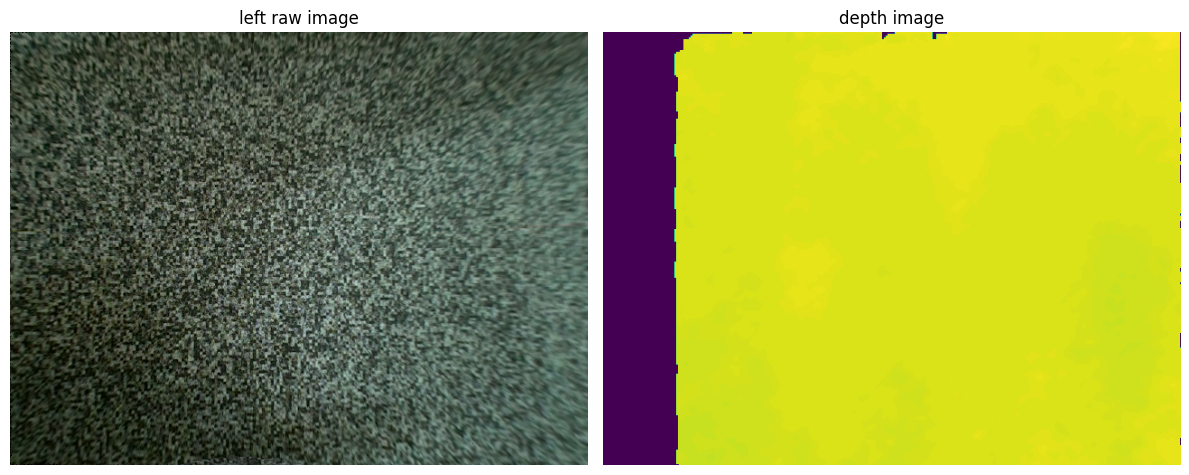

In [2]:
depth_path1 = "data/N9/image_data/106_N09ASH24DH0012_2024_05_06_18_45_09/DEPTH/raw/Depth-2024-5-6-18-45-9-281-1-1155-157441464.raw"
lraw_path1 = "data/N9/image_data/106_N09ASH24DH0012_2024_05_06_18_45_09/LRAW/Depth-left-2024-5-6-18-45-9-281-1-1155-157441464.png"

plot_illustration_fig(lraw_path1, depth_path1)

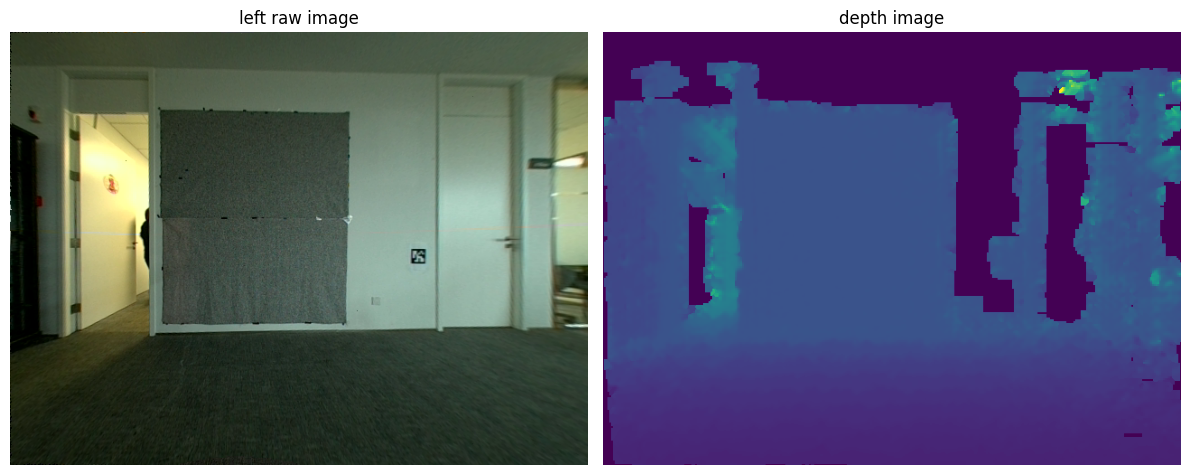

In [3]:
depth_path2 = "data/N9/image_data/1604_N09ASH24DH0012_2024_05_07_13_37_50/DEPTH/raw/Depth-2024-5-7-13-37-50-115-1-1416-196356110.raw"
lraw_path2 = "data/N9/image_data/1604_N09ASH24DH0012_2024_05_07_13_37_50/LRAW/Depth-left-2024-5-7-13-37-50-115-1-1416-196356110.png"

plot_illustration_fig(lraw_path2, depth_path2)

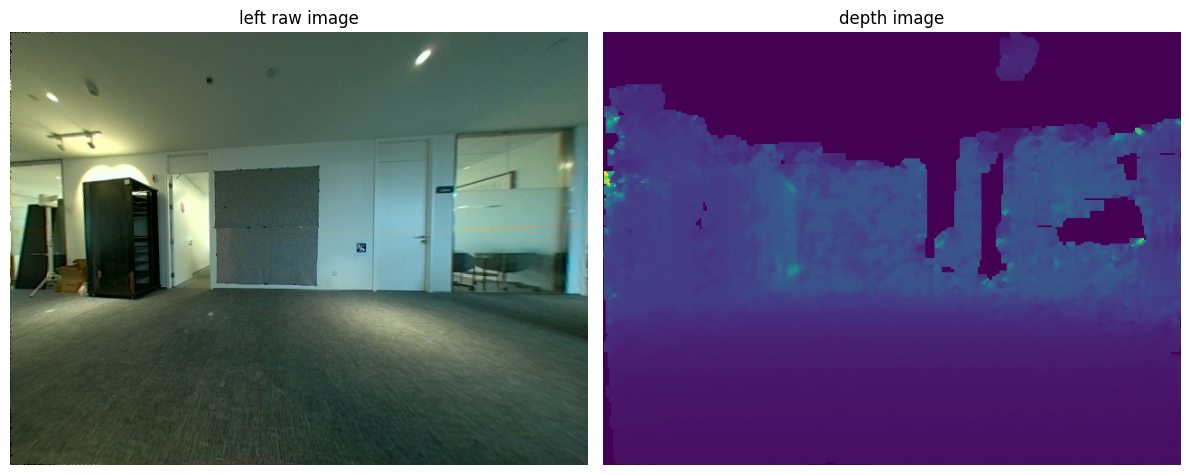

In [4]:
depth_path3 = "data/N9/image_data/3003_N09ASH24DH0012_2024_05_07_14_18_30/DEPTH/raw/Depth-2024-5-7-14-18-31-215-1-7980-1068097965.raw"
lraw_path3 = "data/N9/image_data/3003_N09ASH24DH0012_2024_05_07_14_18_30/LRAW/Depth-left-2024-5-7-14-18-31-215-1-7980-1068231296.png"

plot_illustration_fig(lraw_path3, depth_path3)

We can tell, the target area(gray map rectangle) is not strictly in the center and is not perpendicular(has the rotation angle) to our camera.

## Optimization Goal

define **KB** model as:
$$y_{/text{hat}} = k /cdot x_{/text{hat}} + b$$
$$/text{cost}_{/text{KB}}(k, b) = /frac{1}{n} /sum_{i=1}^{n} (d_i - y_{/text{hat}, i})^2$$

define **KBD** model as:
$$y_{/text{hat}} = /frac{k /cdot f /cdot b}{/bar{d} + /delta} + b$$
$$/text{cost}_{/text{KBD}}(k, /delta, b) = /text{MSE}$$
$$/text{MSE} = /frac{1}{n} /sum_{i=1}^{n} (d_i - y_{/text{hat}, i})^2$$


## Optimization Method Selection

For cost optimization step, we choose **Nelder-Mead** instead of **BFGS** solver. Since **BFGS** would throw 'The optimization did not converge: Desired error not necessarily achieved due to precision loss.' message due to the negative value presence in the gradient flow.

In [3]:
data_path = "data/N9/dq_0509.csv"
data = pd.read_csv(data_path)

# Extracting necessary columns
actual_depth = data["actual_depth"]
fit_depth = data["fit_depth"]
# avg_depth = data["avg_depth"]
# avg_disp = data["avg_disp"]
# avg_depth_50x50 = data["avg_depth_50x50"]
# avg_disp_50x50 = data["avg_disp_50x50"]
avg_depth_50x50_anchor = data["avg_depth_50x50_anchor"]
avg_disp_50x50_anchor = data["avg_disp_50x50_anchor"]
fit_disp = data["fit_disp"]
error_rate = data["error_percentage"]
error = data["absolute_error"]

baseline = data["baseline"].iloc[0] 
focal = data["focal"].iloc[0] 

In [4]:
data

,Unnamed: 0,actual_depth,fit_depth,error_percentage,absolute_error,baseline,focal,avg_depth_50x50_anchor,avg_disp_50x50_anchor,actual_disp,fit_disp
0,0,106,102.0,-3.773585,-4.0,52.916119,166.366119,102.158987,86.174008,83.051409,86.308327
1,1,155,148.7,-4.064516,-6.3,52.916119,166.366119,150.414320,58.528000,56.796447,59.202753
2,2,207,202.5,-2.173913,-4.5,52.916119,166.366119,203.721600,43.213137,42.528741,43.473824
3,3,250,245.3,-1.880000,-4.7,52.916119,166.366119,244.228133,36.046008,35.213797,35.888501
4,4,300,295.7,-1.433333,-4.3,52.916119,166.366119,293.806160,29.963461,29.344831,29.771557
5,5,350,349.1,-0.257143,-0.9,52.916119,166.366119,348.504133,25.260674,25.152712,25.217558
6,6,400,399.1,-0.225000,-0.9,52.916119,166.366119,399.523307,22.034883,22.008623,22.058254
7,7,453,450.6,-0.529801,-2.4,52.916119,166.366119,445.513520,19.760229,19.433663,19.537171
8,8,499,493.5,-1.102204,-5.5,52.916119,166.366119,489.437813,17.986860,17.642183,17.838803
9,9,548,549.5,0.273723,1.5,52.916119,166.366119,549.873280,16.009960,16.064689,16.020836


Comparsion of actual_depth, fit plane depth, center half size crop depth, center 50x50 size crop depth, 50x50 size with anchor point crop depth.

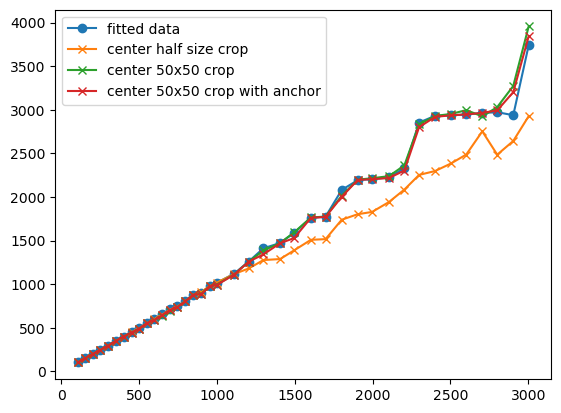

In [137]:
plot_comparison4(actual_depth, fit_depth, avg_depth, avg_depth_50x50, avg_depth_50x50_anchor)

Starting optimization for KB model with center half size average ...
Optimization Results:
Parameters (k, b): [  1.06455585 -27.96245683]
Minimum MSE: 3864.1968253056157
The optimization converged successfully.


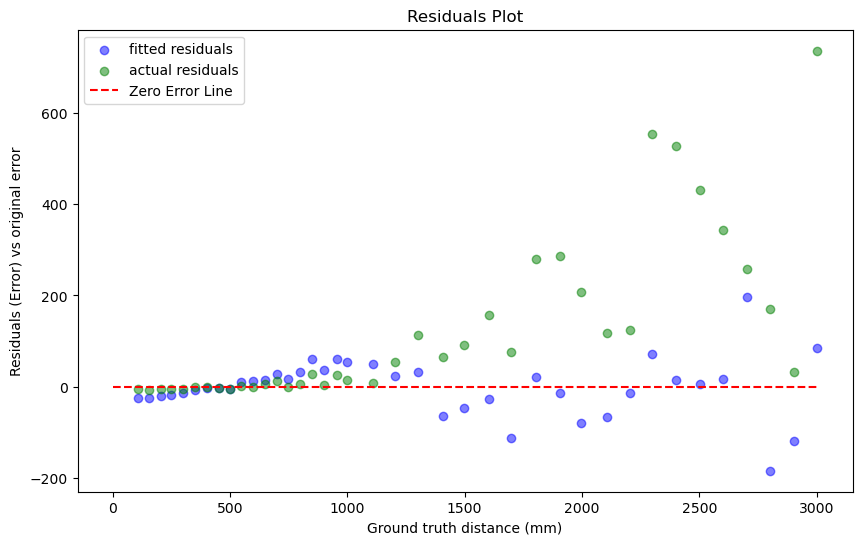

Mean of residuals: 2.7373816478232653e-05


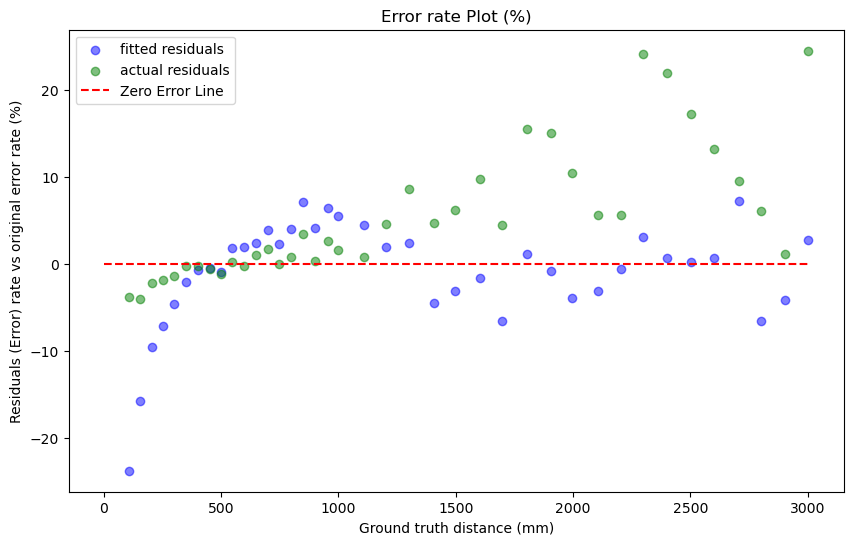

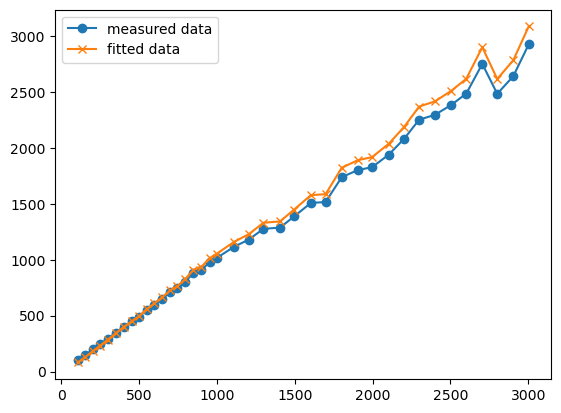

In [138]:
pipeline(actual_depth, avg_depth, error, method='KB', desc='center half size average')

Starting optimization for KB model with center 50x50 crop average ...
Optimization Results:
Parameters (k, b): [  0.82854597 116.34865927]
Minimum MSE: 9716.872875724459
The optimization converged successfully.


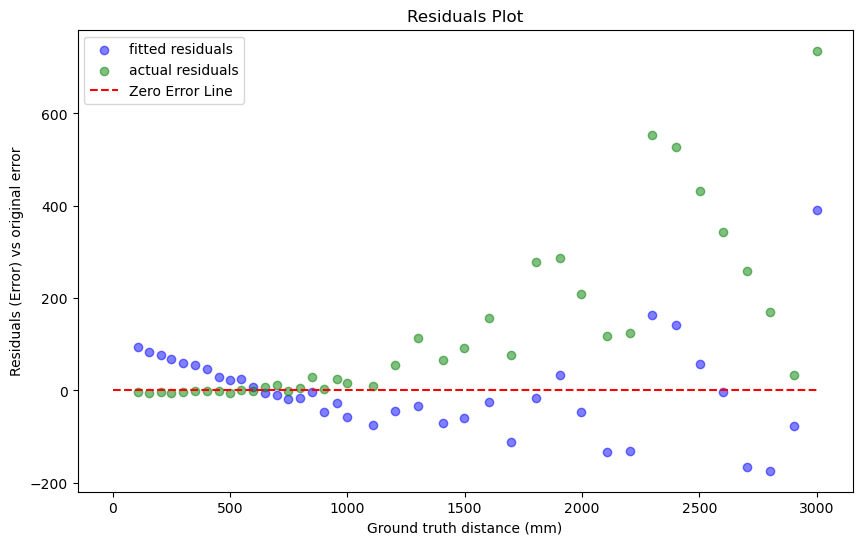

Mean of residuals: -1.116982656558554e-05


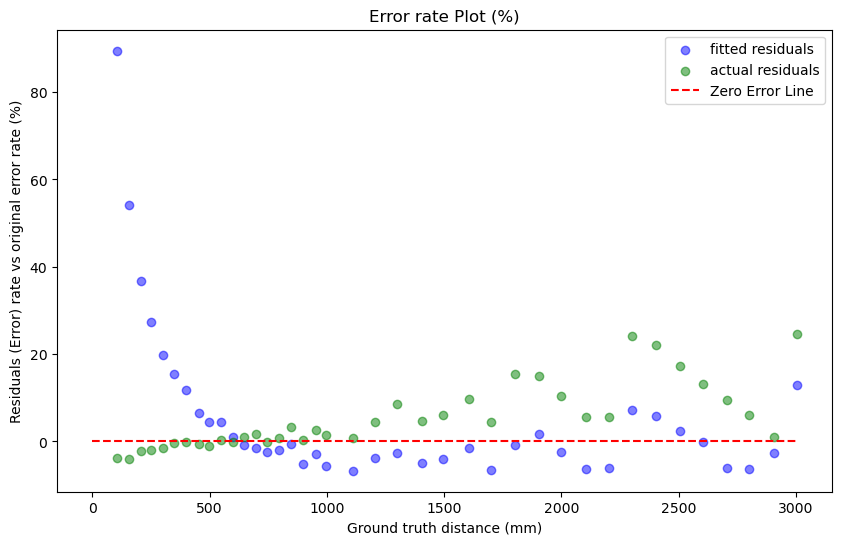

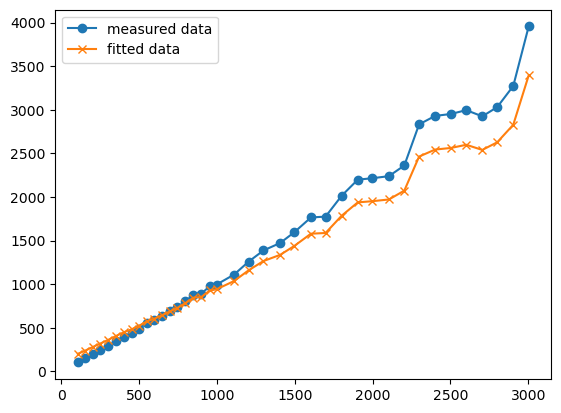

In [139]:
pipeline(actual_depth, avg_depth_50x50, error, method='KB', desc='center 50x50 crop average')

Starting optimization for KB model with center 50x50 crop with anchor point average ...
Optimization Results:
Parameters (k, b): [  0.84225846 107.20152693]
Minimum MSE: 8844.673761986507
The optimization converged successfully.


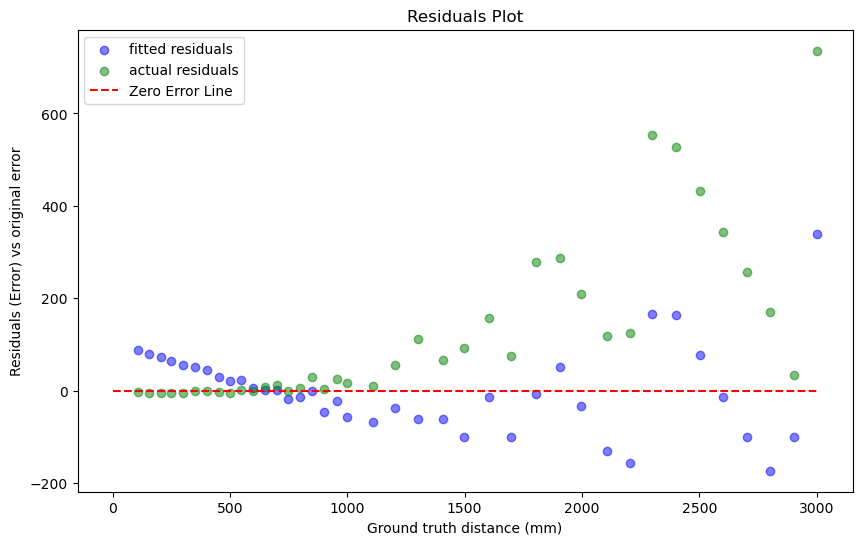

Mean of residuals: 4.199516858085563e-05


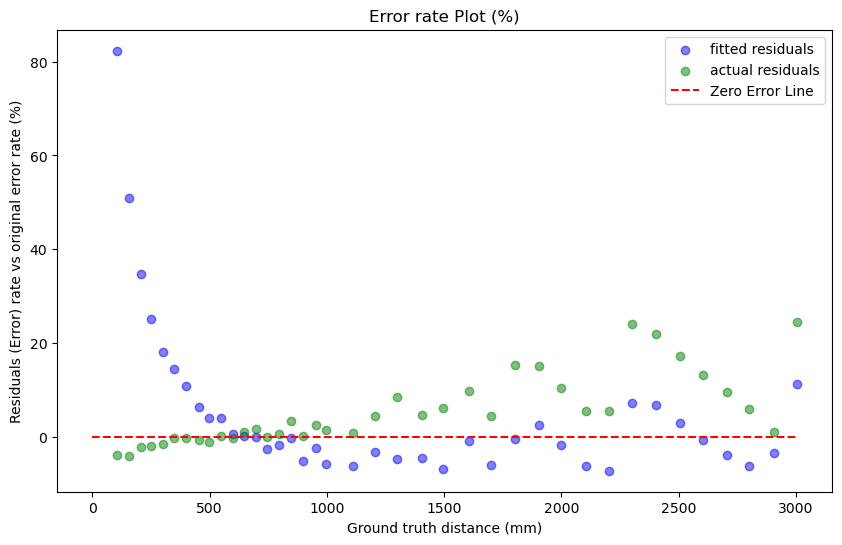

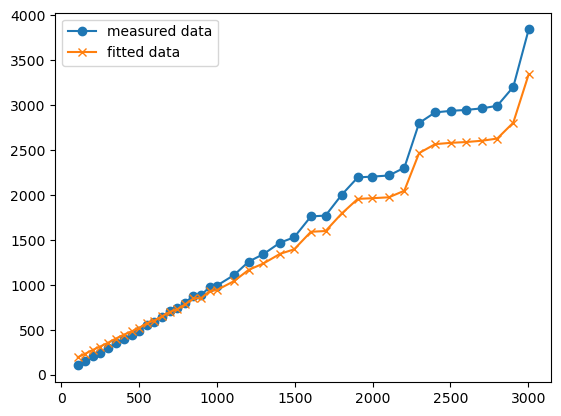

In [140]:
pipeline(actual_depth, avg_depth_50x50_anchor, error, method='KB', desc='center 50x50 crop with anchor point average')

Starting optimization for KBD model with center half size average ...
Optimization Results:
Parameters (k, delta, b): [  1.09204525   0.0791262  -40.81396344]
Minimum MSE: 3830.4075007964498
The optimization converged successfully.


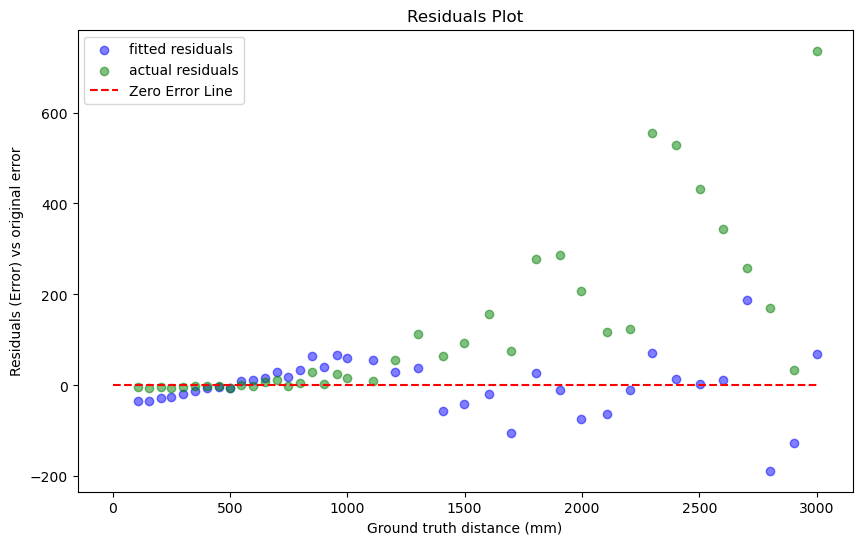

Mean of residuals: 3.475652612486066e-06


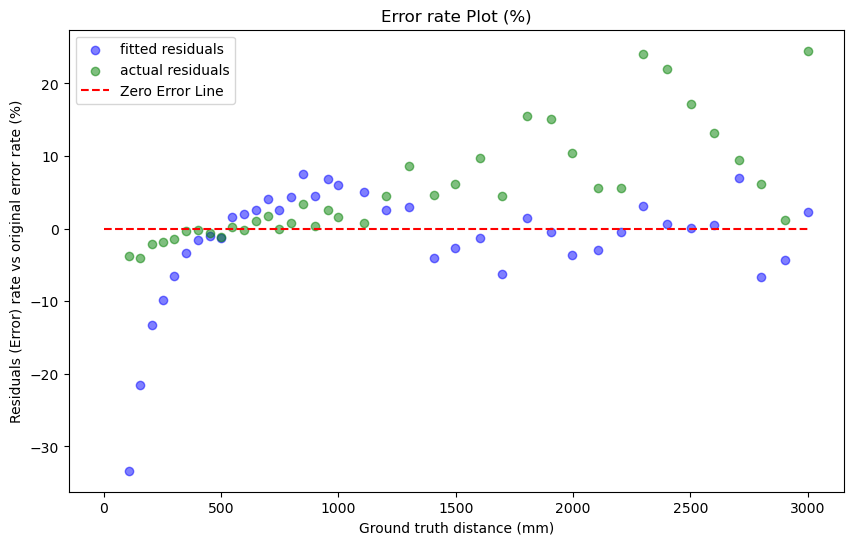

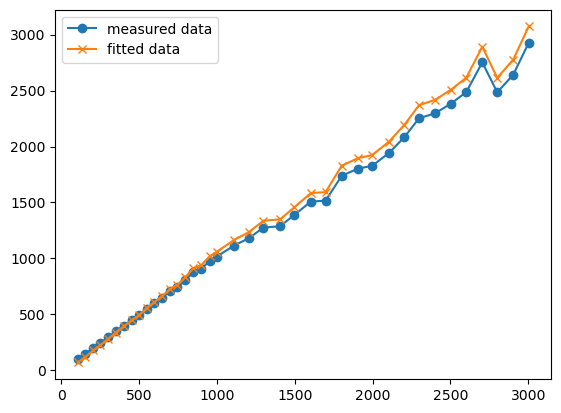

In [141]:
pipeline(actual_depth, avg_disp, error, method='KBD', focal=focal, baseline=baseline, desc='center half size average')

Starting optimization for KBD model with center 50x50 crop size average ...
Optimization Results:
Parameters (k, delta, b): [  1.10857649   0.82553214 -21.63261341]
Minimum MSE: 5270.513721166689
The optimization converged successfully.


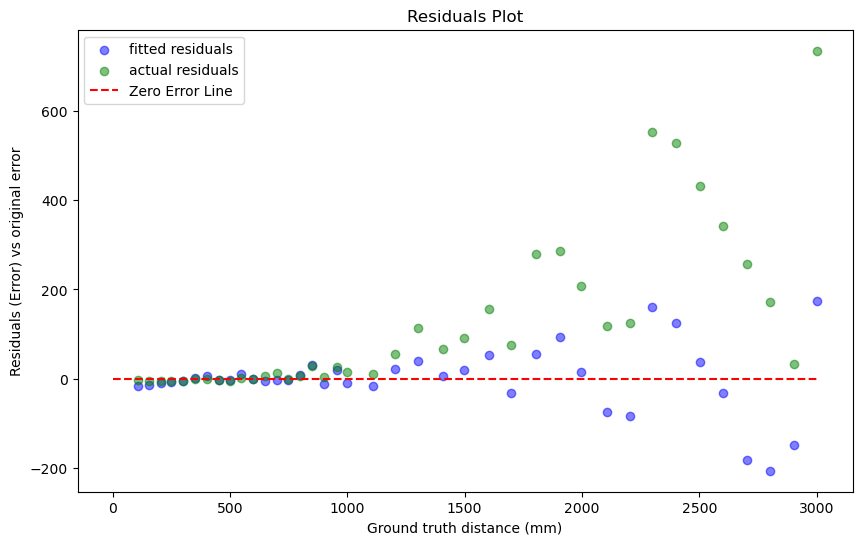

Mean of residuals: -9.00036903827547e-06


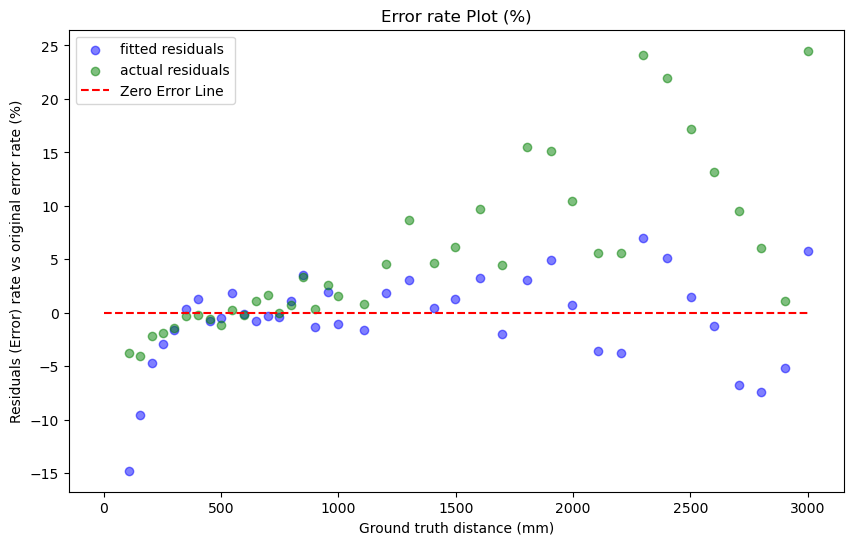

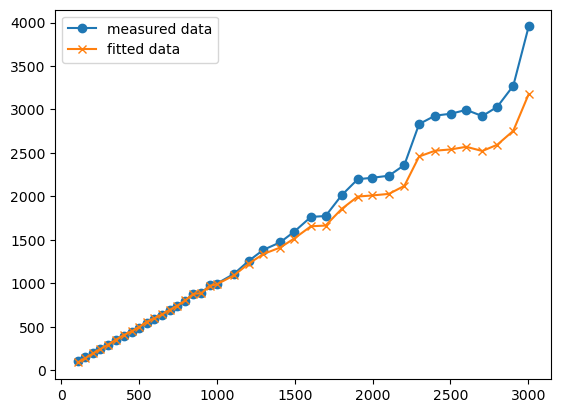

In [142]:
pipeline(actual_depth, avg_disp_50x50, error, method='KBD', focal=focal, baseline=baseline, desc='center 50x50 crop size average')

Starting optimization for KBD model with center 50x50 crop with anchor point size average ...
Optimization Results:
Parameters (k, delta, b): [  1.1052267    0.7752593  -21.72799243]
Minimum MSE: 5141.174009461506
The optimization converged successfully.


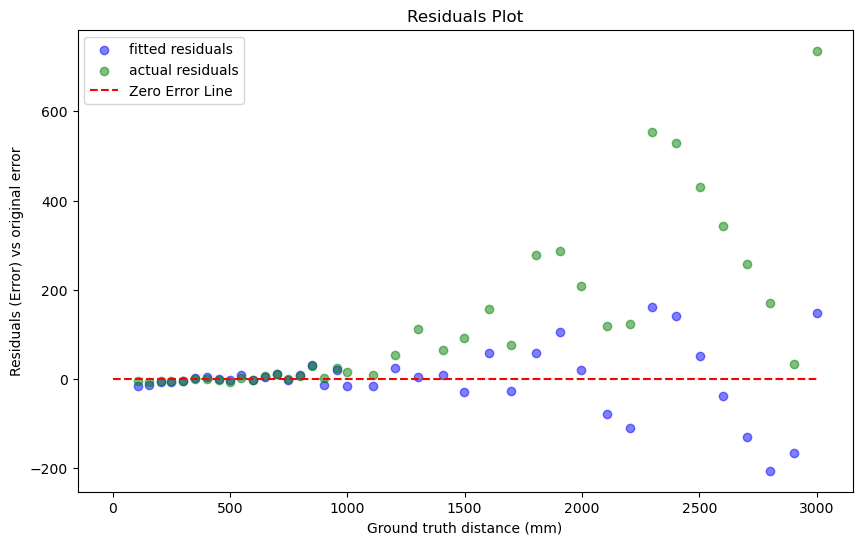

Mean of residuals: -2.8164175686330193e-05


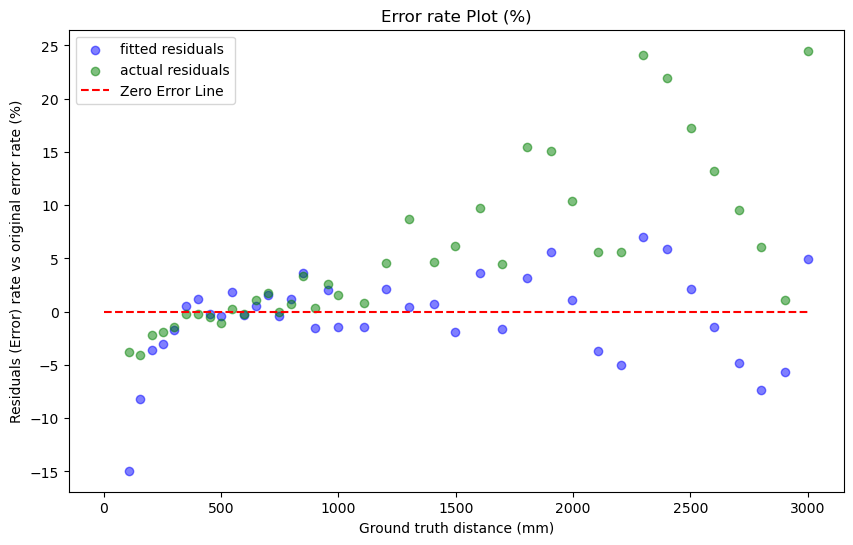

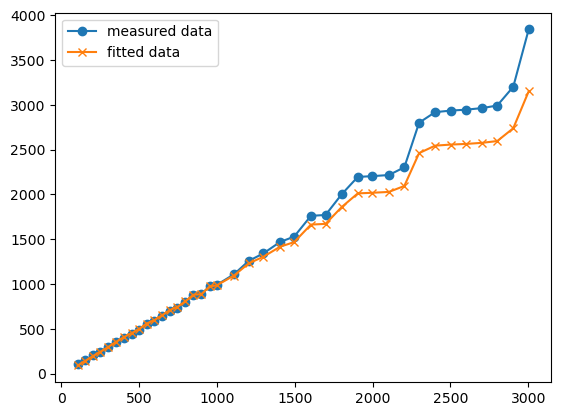

In [143]:
pipeline(actual_depth, avg_disp_50x50_anchor, error, method='KBD', focal=focal, baseline=baseline, desc='center 50x50 crop with anchor point size average')

Starting optimization for KBD L2 regularization model with center 50x50 crop with anchor point size average ...
Optimization Results:
Parameters (k, delta, b): [ 1.07146822  0.69087342 -0.10980106]
Minimum MSE: 5197.531673899018
The optimization converged successfully.


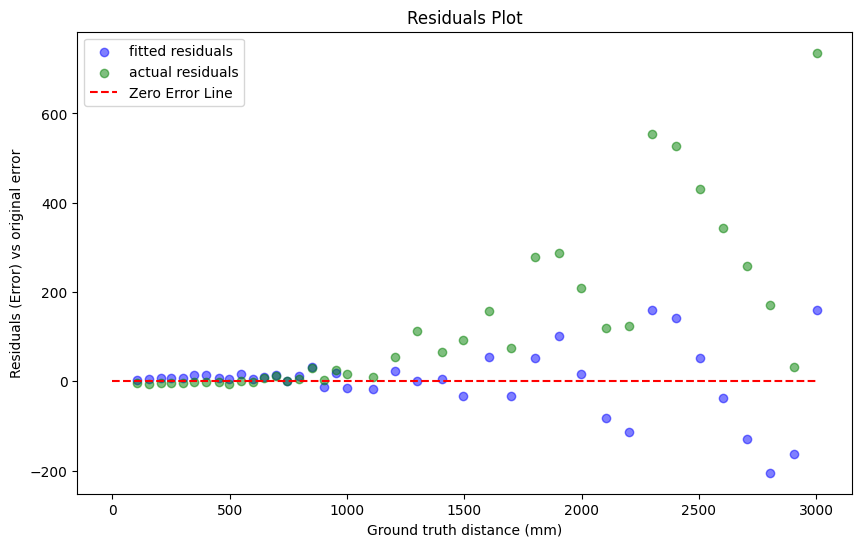

Mean of residuals: 2.6286783646115603


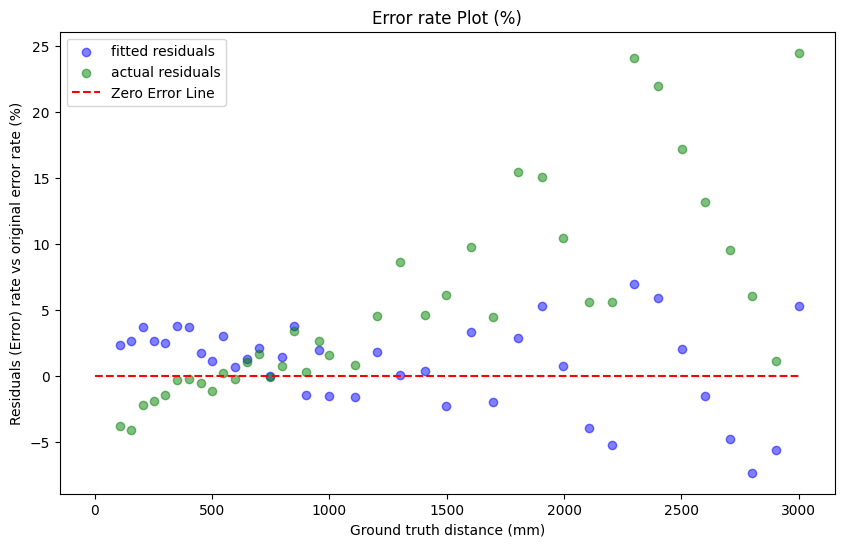

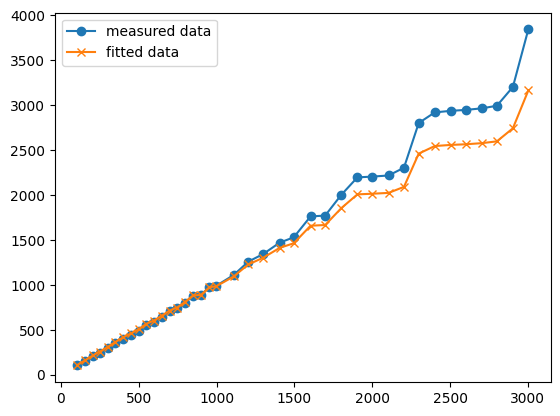

In [14]:
pipeline(actual_depth, avg_disp_50x50_anchor, error, method='KBD_reg', focal=focal, baseline=baseline, desc='center 50x50 crop with anchor point size average')

Starting optimization for KBD L2 regularization model with center 50x50 crop with anchor point size average ...
Optimization Results:
Parameters (k, delta, b): [ 1.0714652   0.69089597 -0.10980481]
Minimum MSE: 5197.546430910979
The optimization converged successfully.


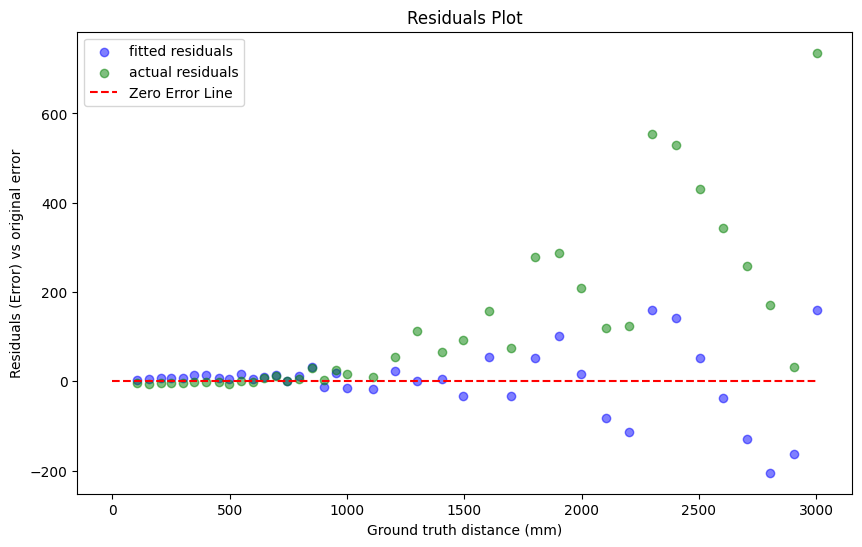

Mean of residuals: 2.6189556416921844


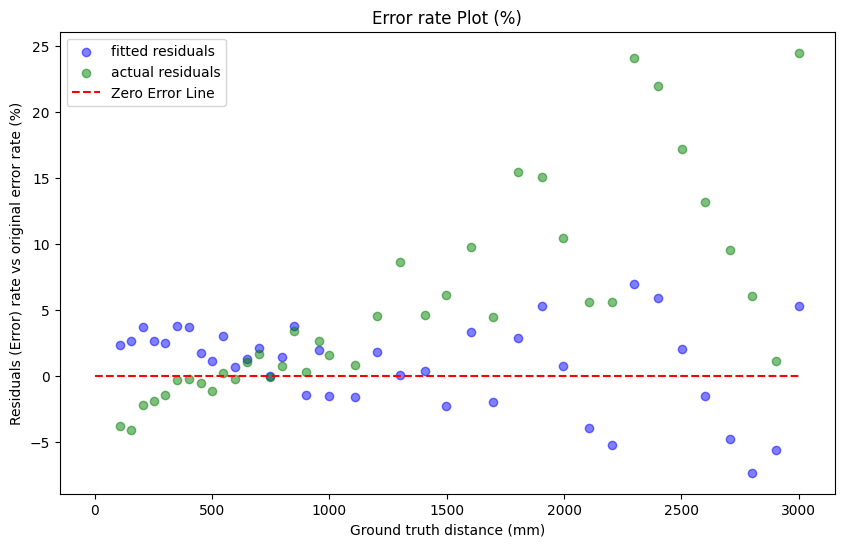

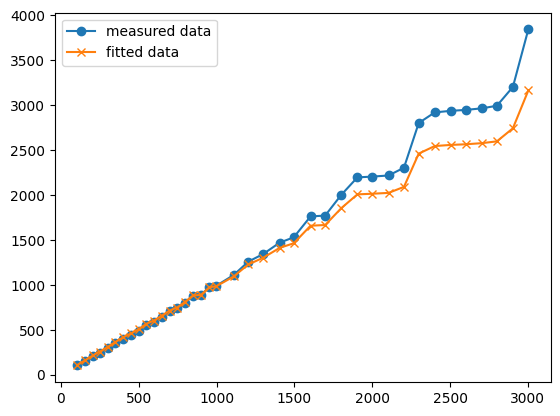

In [24]:
pipeline(actual_depth, avg_disp_50x50_anchor, error, method='KBD_reg', focal=focal, baseline=baseline, desc='center 50x50 crop with anchor point size average', reg_lambda=0.01)

Starting optimization for 2 degrees polynomial L2 regularization model with center 50x50 crop with anchor point size average ...
Optimization Results:
Parameters (k, delta, b): [0.00250834 0.90309701 0.71308382 0.10320792]
Minimum MSE: 5135.478653185766
The optimization converged successfully.


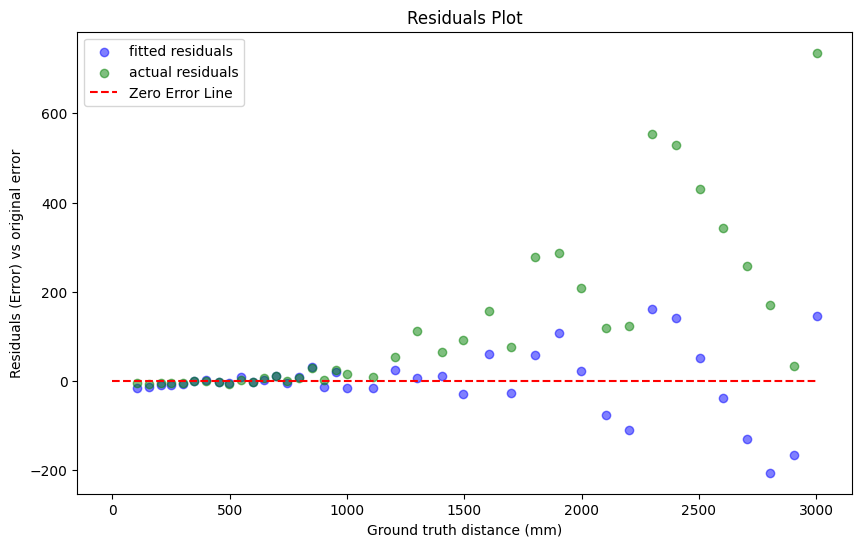

Mean of residuals: -0.2496056290474852


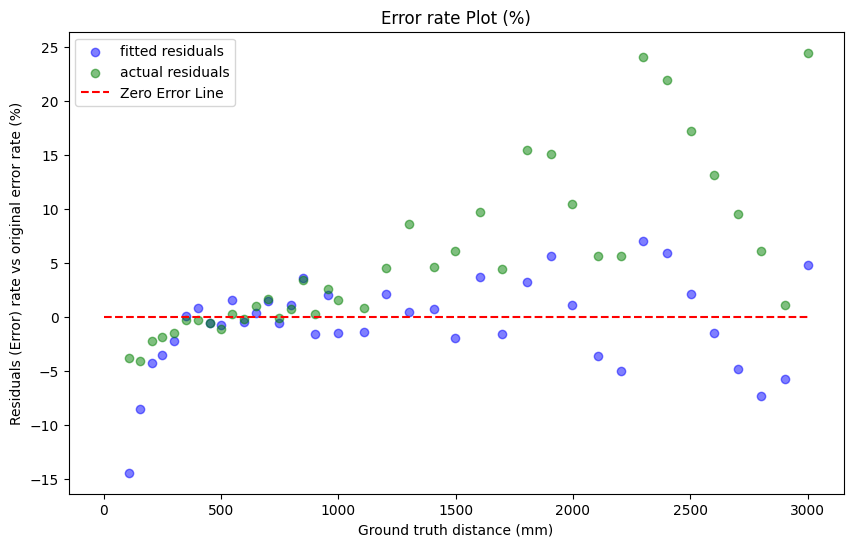

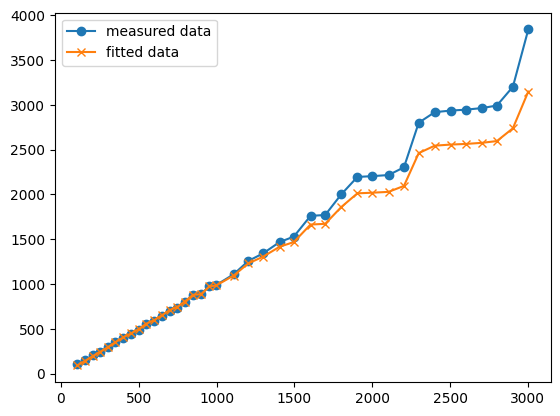

In [32]:
pipeline(actual_depth, avg_disp_50x50_anchor, error, method='poly_n2', focal=focal, baseline=baseline, desc='center 50x50 crop with anchor point size average', reg_lambda=0.001)

Starting optimization for piecewise KBD model optimization with center 50x50 crop with anchor point size average ...


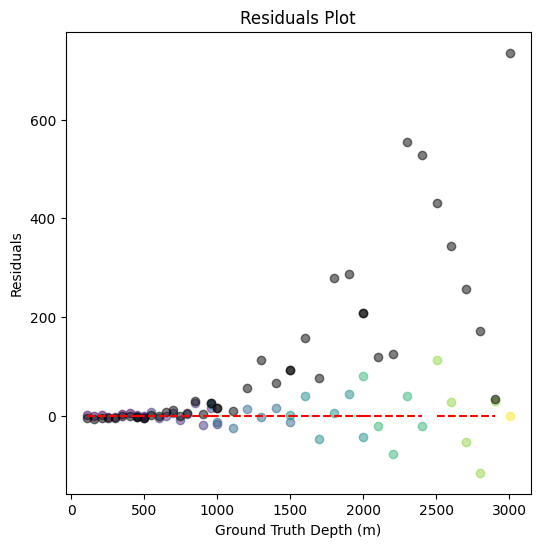

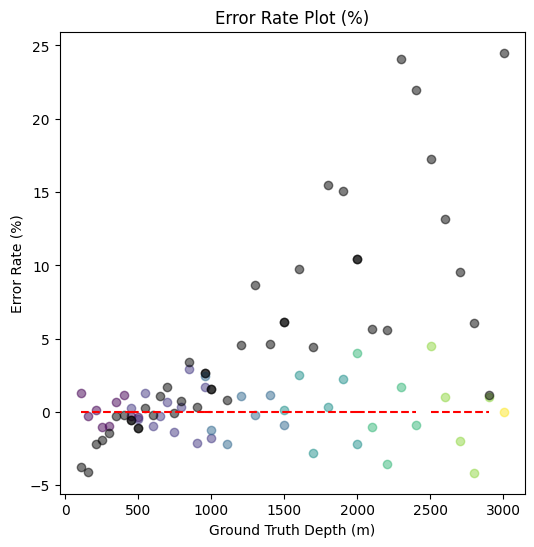

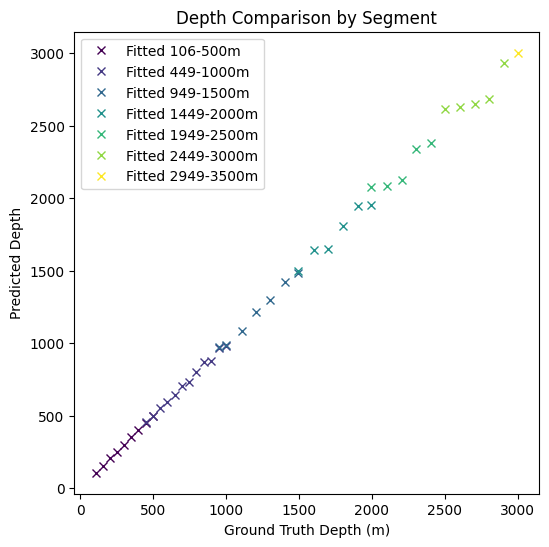

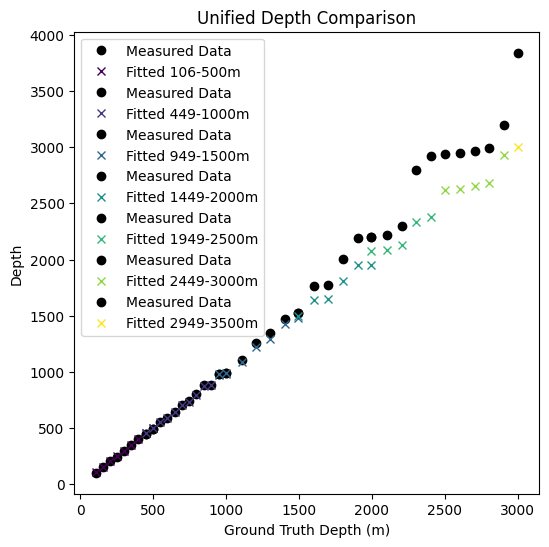

In [28]:
depth_ranges = [
    (106, 500),
    (449, 1000),
    (949, 1500),
    (1449, 2000),
    (1949, 2500),
    (2449, 3000),
    (2949, 3500)
]
pipeline(actual_depth, avg_disp_50x50_anchor, error, method='KBD_seg', focal=focal, baseline=baseline, desc='center 50x50 crop with anchor point size average', depth_ranges=depth_ranges)


## Anthoer model

In [9]:
MAPPED_PAIR_DICT = {
    "距离(mm)": "actual_depth",
    "相机焦距": "focal",
    "相机基线": "baseline",
    "绝对误差/mm": "absolute_error",
}

def read_excel(path: str) -> pd.DataFrame:
    return pd.read_excel(path)

def read_table(path: str, pair_dict: dict) -> pd.DataFrame:
    df = read_excel(path)
    df_sel = df[list(pair_dict.keys())]
    needed_df = df_sel.rename(columns=pair_dict)
    return needed_df

In [12]:
tabel_path = "data/N9_concat/dq_0513.csv"
df = pd.read_csv(tabel_path)
df

,Unnamed: 0,actual_depth,focal,baseline,absolute_error,avg_depth_50x50_anchor,avg_disp_50x50_anchor
0,0,153,266.362671,54.609032,0.9,154.000000,94.453296
1,1,202,266.362671,54.609032,-1.9,201.825347,72.071263
2,2,298,266.362671,54.609032,-1.0,301.776440,48.200607
3,3,401,266.362671,54.609032,-1.2,403.006880,36.093199
4,4,501,266.362671,54.609032,2.0,501.105520,29.027434
5,5,601,266.362671,54.609032,1.2,605.009480,24.042281
6,6,703,266.362671,54.609032,-0.5,697.988133,20.839620
7,7,804,266.362671,54.609032,12.3,807.384787,18.015955
8,8,904,266.362671,54.609032,1.9,909.330493,15.996173
9,9,1003,266.362671,54.609032,21.5,1026.298893,14.173072


In [24]:
actual_depth = df["actual_depth"].values
avg_depth_50x50_anchor = df["avg_depth_50x50_anchor"].values
avg_disp_50x50_anchor = df["avg_disp_50x50_anchor"].values
error = df["absolute_error"].values

baseline = df["baseline"].iloc[0] 
focal = df["focal"].iloc[0] 

Starting optimization for piecewise KBD model optimization with center 50x50 crop with anchor point size average ...


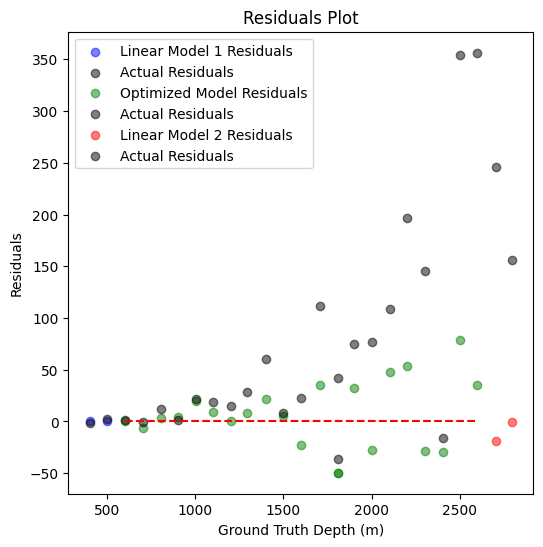

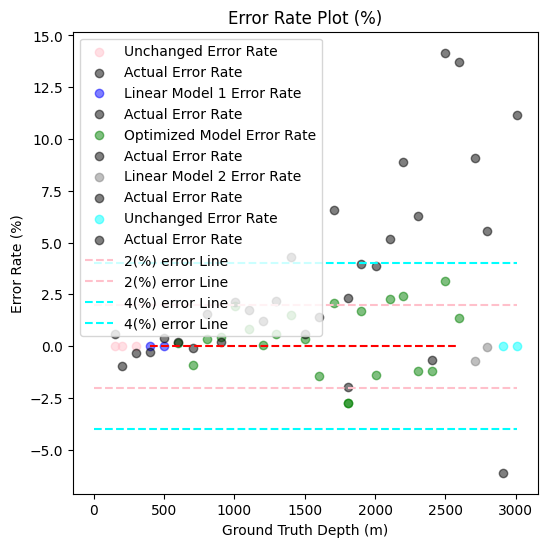

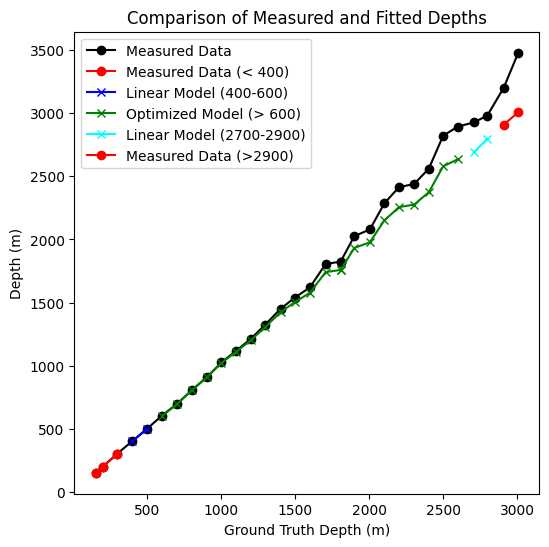

In [55]:
disjoint_depth_ranges = (400, 600, 2700, 2900)
pipeline(actual_depth, avg_disp_50x50_anchor, error, method='KBD_linear', focal=focal, baseline=baseline, desc='center 50x50 crop with anchor point size average', disjoint_depth_ranges=disjoint_depth_ranges)